<a href="https://colab.research.google.com/github/Axis121/AMLS_assignment22_23/blob/main/A2/A2_Emotion_Manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#https://towardsdatascience.com/basic-smile-detection-using-opencv-and-dlib-aeb22afb9e67


In [ ]:
## general imports
import cv2 # manipulating images
import dlib # for face detection
from google.colab.patches import cv2_imshow 
from natsort import natsorted 
import os # to navigate file directories
from os import listdir
import pickle # used to save models

## imports for manipulating and visualising data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2 # test to select most signifacnt features
from sklearn.preprocessing import StandardScaler

## imports for model building
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # cross validation/ grid search for hyper-parameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

## imports for model evaluation
from sklearn import metrics
import seaborn as sns # graphing confusion matrices
from sklearn.model_selection import learning_curve # plot learning curve for a model

##move all imports here


In [ ]:
def faceLandmarks(im):

    # Path for the detection model
    PREDICTOR_PATH = r"/content/drive/MyDrive/Colab Notebooks/Test_folder/shape_predictor_68_face_landmarks.dat"
    
    # Create object to detect the face
    faceDetector = dlib.get_frontal_face_detector()

    # Create object to detect the facial landmarks
    landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

    # Detect faces
    faceRects = faceDetector(im, 0)

    # Initialize landmarksAll array
    landmarksAll = []

    # For each face detected in the image, this chunk of code creates a ROI around the face and pass it as an argument to the 
    # facial landmark detector and append the result to the array landmarks 
    for i in range(0, len(faceRects)):
        newRect = dlib.rectangle(int(faceRects[i].left()),
                            int(faceRects[i].top()),
                            int(faceRects[i].right()),
                            int(faceRects[i].bottom()))
        landmarks = landmarkDetector(im, newRect)
        landmarksAll.append(landmarks)

    return landmarksAll, faceRects


In [ ]:
def renderFacialLandmarks(im, landmarks):
    
    # Convert landmarks into iteratable array
    points = []
    [points.append((p.x, p.y)) for p in landmarks.parts()]

    # Loop through array and draw a circle for each landmark
    for p in points:
        cv2.circle(im, (int(p[0]),int(p[1])), 2, (255,0,0),-1)

    # Return image with facial landmarks 
    return im

Extractions of features

In [ ]:
def extractFeatures(folder_dir): 
    number_of_features = 136 #68 coordinates, x and y points
    features = np.ones((1,number_of_features))*10
    current_features = np.zeros((1,number_of_features))

    for images in natsorted(os.listdir(folder_dir)):
    
        # check if the image ends with png
        if (images.endswith(".jpg")):
            
            #print(images) # for testing
            ##use images to finish the directory call for im
            ## Read an image to a variable
            im = cv2.imread(folder_dir +"/" + images)
            
            # Get landmarks using the function created above
            landmarks, _ = faceLandmarks(im)

            if len(landmarks) == 0: # set image row to 0 if no face detected
                for j in range(68):
                  current_features [0,j]=0
                  current_features [0,j+68]=0

            else:
                # Render the landmarks on the first face detected. You can specify the face by passing the desired index to the landmarks array.
                # In this case, one face was detected, so I'm passing landmarks[0] as the argument.
                faceWithLandmarks = renderFacialLandmarks(im, landmarks[0])
                for j in range(68):
                  #print(j)
                  current_features [0,j]=landmarks[0].parts()[0].x-landmarks[0].parts()[j].x
                  current_features [0,j+68]=landmarks[0].parts()[0].y-landmarks[0].parts()[j].y
        features = np.vstack((features,current_features)) # vertically combine the returned feature array of each image
    
    features = np.delete(features,0,axis = 0) # remove placeholder first row, does not represent an image
    return features
    print("done")  

In [ ]:
def getSelectedFacialFeatures(features): # derive the specific features from the landmark coordinates
  rows, cols = features.shape
  number_of_features = 16
  x = features [:,:68] # extract x coordinates from features matrix
  y = features [:,-68:] # extract y coordinates from features matrix

  selected_features = np.zeros((rows,number_of_features))

  # lip width
  selected_features [:,0] = x[:,48] - x[:,54]

  # jaw width
  selected_features [:,1] = x[:,2] - x[:,14]

  # ratio of lip and jaw width
  #selected_features [:,2] = selected_features [:,0]/selected_features [:,1]

  # MAR (Mouth Aspect Ratio) (a1 + a2)/(2*a3)
  a1 = y[:,50] - y[:,58]
  a2 = y[:,51] - y[:,57]
  a3 = y[:,52] - y[:,56]
  a4 = x[:,48] - x[:,54]

  #selected_features [:,3] = (a1+a2+a3)/(3*a4) 

  # Cheek puffiness
  selected_features [:,4] = y[:,11] - y[:,30]

  # lip curvature ## check formula
  selected_features [:,5] = y[:,60] - y[:,66]

  # Mouth corners
  selected_features [:,6] = x[:,48]
  selected_features [:,7] = y[:,48]

  selected_features [:,8] = x[:,54]
  selected_features [:,9] = y[:,54]

  # eye corners

  selected_features [:,10] = x[:,16]
  selected_features [:,11] = y[:,16]

  selected_features [:,12] = x[:,20]
  selected_features [:,13] = y[:,20]

  selected_features [:,14] = x[:,21]
  selected_features [:,15] = y[:,21]

  selected_features [:,3] = x[:,25]
  selected_features [:,2] = y[:,25]

  return abs(selected_features)

In [ ]:
def getLabel(label_dir,column):
  df = pd.read_csv(label_dir)

  ## replace "-1" labels with a "0"
  df = df.replace(-1,0)
  labels = df.iloc[:,column].values #face shape is the 3rd coloumn, eye colour is the 2nd
  labels = np.transpose(labels)

  return labels

In [ ]:
def removeMissingValues (features, labels):

  rows, cols = features.shape
  featuresAndLabels = np.column_stack((features,labels)) # combine the features and labels into one matrix, horizontally
  featuresAndLabels = featuresAndLabels[~np.all(featuresAndLabels[:,:136] == 0, axis=1)] #remove rows if the feature row section is full of zeroes
  featuresAndLabels = featuresAndLabels[~np.any(np.isnan(featuresAndLabels[:,:136])==True, axis=1)] #remove rows if the feature row section is full of zeroes
  featuresAndLabels = featuresAndLabels[~np.any(np.isinf(featuresAndLabels[:,:136])==True, axis=1)] #remove rows if the feature row section is full of zeroes

  clean_features = featuresAndLabels [:,:cols] # remake feature matrix
  clean_labels = featuresAndLabels [:,-1] # remake label vector

  return clean_features, clean_labels

In [ ]:
def removeMissingColoumns (features, labels):

  rows, cols = features.shape
  featuresAndLabels = np.column_stack((features,labels)) # combine the features and labels into one matrix, horizontally

  is_zero_col = np.all(featuresAndLabels == 0, axis=0)
  is_nan_col = np.all(np.isnan(featuresAndLabels), axis=0)
  is_inf_col = np.all(np.isinf(featuresAndLabels), axis=0)

  is_special_col = np.logical_or(is_nan_col, is_inf_col,is_zero_col)

  featuresAndLabels = np.delete(featuresAndLabels, np.where(is_special_col), axis=1)

  clean_features = featuresAndLabels [:,:cols] # remake feature matrix
  clean_labels = featuresAndLabels [:,-1] # remake label vector

  return clean_features, clean_labels

In [ ]:
## initial extraction of features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/celeba/img" # training + validation iamges
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/CelebA_feature_set.npy",features)

Loading saved features and importing labels

In [ ]:
features = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/CelebA_feature_set.npy")

In [ ]:
## obtaining labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/Datasets/celeba/labels_modified.csv' # training + validation labels
labels = getLabel(label_dir,column = 3) # get label vector #gender is the 3rd column, smile is the 4th

Dataset Pre-Processing Stage


In [ ]:
# get selected facial features
selected_features = getSelectedFacialFeatures (features)
#remove rows with missing values
clean_features, clean_labels = removeMissingValues (selected_features, labels)

Visualisation of Data


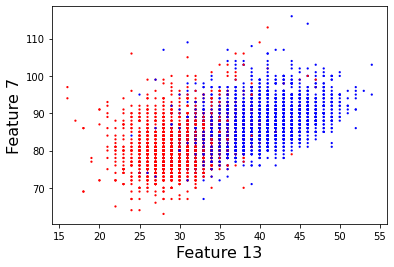

In [ ]:
## plot features against each other with points coloured based on label
col = np.where(clean_labels>0,'b','r') # assign colour based on label

plt.scatter(clean_features[:,0], clean_features[:,1], c=col, s=5, linewidth=0)
plt.xlabel("Feature 13",fontsize=16)
plt.ylabel("Feature 7",fontsize=16)
plt.show()

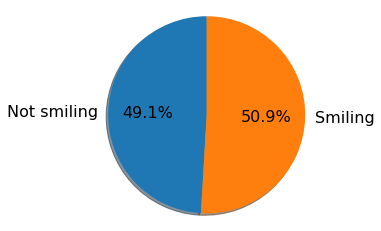

In [ ]:
## Pie Chart Visualisation
unique, counts = np.unique(clean_labels, return_counts=True)

# Make pie chart
labels = 'Not smiling', 'Smiling'
sizes = counts
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 16})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Splitting processed data into training and validation image sets.

In [ ]:
X_train, X_validate, Y_train, Y_validate = train_test_split(clean_features, clean_labels, test_size=0.3,random_state=109) # 70% training and 30% test

Obtain test set from separate directory of images

In [ ]:
## Extract Features
folder_dir = "/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/celeba_test/img" # test set
features = extractFeatures(folder_dir)
np.save("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/celebA_feature_test_set.npy",features) # saving features to a file

In [ ]:
## reload features from saved file and get labels
features_test = np.load("/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/A1/celebA_feature_test_set.npy")

## labels
label_dir = '/content/drive/MyDrive/Colab Notebooks/Test_folder/Upload/dataset_AMLS_22-23_test/celeba_test/labels_modified.csv' # test set labels
labels_test = getLabel(label_dir, column = 3) # get label vector #face shape is the 3rd column, eye colour is the 2nd

# get selected facial features
selected_features_test = getSelectedFacialFeatures (features_test)

## Match naming conventions
X_test = selected_features_test
Y_test = labels_test

Building Machine Learning Models: Training, Validation and Testing

In [ ]:
## scaling/normalising feature matrices of each set
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)  
X_test_s = scaler.transform(X_test)
X_validate_s = scaler.transform(X_validate)

In [ ]:
# Alternate normalisation method
# features required to be normalised to allow convegrence when fitting model
X_validate_normalised = X_validate / X_validate.max(axis=0)
X_train_normalised = X_train / X_train.max(axis=0)
X_test_normalised = X_test / X_test.max(axis=0)

Logistic Regression

In [ ]:
## Tuning hyper parameters of logistic regression model using validation set

# defining parameter range
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
      'solver': ['newton-cg', 'lbfgs', 'liblinear'],
      "penalty": ["l2"],
  	  "max_iter": [100, 200, 300, 400, 500, 600, 700, 800]
      }

grid = GridSearchCV(LogisticRegression(), param_grid, verbose = 3)

# fitting the model for grid search
grid.fit(X_validate_normalised, Y_validate)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.860 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.818 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.856 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.901 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.846 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.860 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.818 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.856 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.846 total 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.894 total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.897 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.904 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.856 total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.891 total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.873 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.894 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.908 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.846 total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.897 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.853 total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.898 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.901 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.897 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.853 total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.898 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.1s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.897 total time=   0.1s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.853 total time=   0.1s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.898 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.901 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.897 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.853 total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.898 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.901 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.897 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.853 total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.898 total time=   0.1s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.1s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.901 total time=   0.1s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.897 total time=   0.1s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.853 total time=   0.1s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=libline

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300, 400, 500, 600, 700, 800],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1, solver='newton-cg')


In [ ]:
#ideal parameters
#{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

# train tuned logistic regression model with training set
logr_model = LogisticRegression(C = 1, max_iter = 100, penalty = "l2", solver = "newton-cg")
logr_model.fit(X_train_normalised, Y_train)

# evaluate performance using test set
preds = logr_model.predict(X_test_normalised)
print(metrics.classification_report(preds, Y_test))
cm_logr = metrics.confusion_matrix(Y_test,preds) # stored to be used to graph confusion matrix for report

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86       643
         1.0       0.69      0.97      0.81       357

    accuracy                           0.83      1000
   macro avg       0.83      0.86      0.83      1000
weighted avg       0.88      0.83      0.84      1000



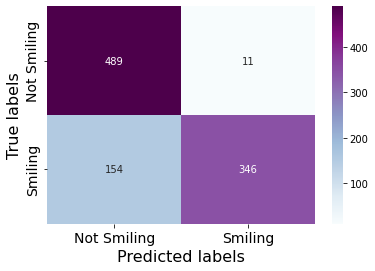

In [ ]:
## Creating confusion matrix plot
ax= plt.subplot()
sns.heatmap(cm_logr, annot=True, fmt='g', ax=ax, cmap="BuPu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16);ax.set_ylabel('True labels', fontsize = 16); 
font_size = 14
ax.tick_params(labelsize=font_size)
ax.xaxis.set_ticklabels(['Not Smiling', 'Smiling']); ax.yaxis.set_ticklabels(['Not Smiling','Smiling',]); # x axis = 0, 1 | y acis = 1,0

In [ ]:
## Tuning hyper parameters of svm rbf model using validation set

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['linear']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_validate, Y_validate)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.898 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.870 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.908 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.901 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.853 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.898 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.870 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.908 total time=   0.1s
[CV 4/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.901 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.853 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.898 total time=   0.1s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear']},
             verbose=3)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVC(C=10, gamma=1, kernel='linear')


In [ ]:
## Validation
grid_predictions = grid.predict(X_test)

# print classification report
print(metrics.classification_report(Y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       478
         1.0       0.92      0.89      0.90       499

    accuracy                           0.90       977
   macro avg       0.90      0.90      0.90       977
weighted avg       0.90      0.90      0.90       977



SVM (Linear)

In [ ]:
## grid searched parameters:
# C = 10, gamma = 1, kernel = linear 

#Create a svm Classifier
rbf_svm_model = svm.SVC(decision_function_shape='ovr',kernel='linear',C=10, gamma=1) #

#Train the model using the training sets
rbf_svm_model.fit(X_train, Y_train)

# Evaluate performance of model using test set
y_pred = rbf_svm_model.predict(X_test)

print(metrics.classification_report(y_pred, Y_test))
cm_svm = metrics.confusion_matrix(Y_test,y_pred) # stored to be used to graph confusion matrix for report

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       498
         1.0       0.88      0.87      0.88       502

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



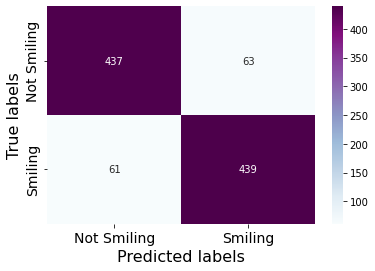

In [ ]:
## Creating confusion matrix plot
ax= plt.subplot()
sns.heatmap(cm_svm, annot=True, fmt='g', ax=ax, cmap="BuPu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16);ax.set_ylabel('True labels', fontsize = 16); 
font_size = 14
ax.tick_params(labelsize=font_size)
ax.xaxis.set_ticklabels(['Not Smiling', 'Smiling']); ax.yaxis.set_ticklabels(['Not Smiling','Smiling',]); # x axis = 0, 1 | y acis = 1,0

Save the model to be reloaded later

In [ ]:
# save the model to disk
filename = 'A2_model.sav'
pickle.dump(rbf_svm_model, open(filename, 'wb')) # actually linear svm

In [ ]:
# load the model from disk
filename = 'A2_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
## Test loaded model
result = loaded_model.score(X_test, Y_test)
print(result)

Examination of Learning Curve

In [ ]:
#rebuild untrained model that achieved highest performance
estimator = svm.SVC(decision_function_shape='ovo',kernel='linear',C=10, gamma=1) #
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X_train, Y_train, cv = 5, return_times=True)

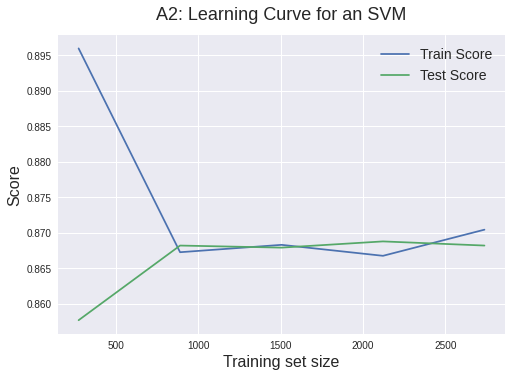

In [ ]:
## plotting learning curve
plt.style.use('seaborn')
plt.plot(train_sizes,np.mean(train_scores,axis=1))
plt.plot(train_sizes,np.mean(test_scores,axis=1))
plt.ylabel('Score', fontsize = 16)
plt.xlabel('Training set size', fontsize = 16)
plt.title('A2: Learning Curve for an SVM', fontsize = 18, y = 1.03)
plt.legend(["Train Score", "Test Score"],prop={'size': 14})
plt.show()